In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import glob
import os
from io import StringIO
from scipy.signal import welch
from scipy.spatial import ConvexHull
import re
from scipy.stats import f_oneway, kruskal
from scipy.signal import detrend

import seaborn as sns

import re
from math import sqrt, pi

from scipy import signal
from scipy import integrate
from ahrs.filters import EKF
from ahrs.common.orientation import q2euler
from ahrs.common.orientation import q2R

The code should run on your computer, just make sure you:
- change the paths accordingly
- install all the packages

In [4]:
def load_txt(file):
    """
    Loads either a .txt or .csv data file into a pandas DataFrame.
    Automatically detects file type, separator, and encoding.
    Cleans up column names for safe downstream processing.
    """
    if file.endswith(".csv"):
        # --- CSV case ---
        try:
            df = pd.read_csv(file, encoding="utf-8")
        except UnicodeDecodeError:
            # Handle Windows or European encodings (μ, °, etc.)
            df = pd.read_csv(file, encoding="latin1")
        except pd.errors.ParserError:
            df = pd.read_csv(file, sep=";", encoding="latin1")
    else:
        # --- TXT case ---
        with open(file, "r", encoding="utf-8", errors="replace") as f:
            lines = f.readlines()
        # Drop empty lines
        lines = [line for line in lines if line.strip()]
        header_line = lines[1].strip().split("\t")
        data_lines = lines[2:]
        df = pd.read_csv(StringIO("".join(data_lines)), sep="\t", names=header_line)
    
    # --- Clean up column names ---
    df.columns = (
        df.columns.str.replace("�", "u", regex=False)   # Replace invalid chars
                   .str.replace("µ", "u", regex=False)
                   .str.strip()
    )
    return df


# --- Folder containing your files ---
folder_path = "measurement"  # change as needed

# --- Find all .txt and .csv files ---
txt_files = glob.glob(os.path.join(folder_path, "*.txt")) + \
            glob.glob(os.path.join(folder_path, "*.csv"))

# --- Read all files into a dictionary ---
data = {}
for file in txt_files:
    df = load_txt(file)
    data[os.path.basename(file)] = df

# --- Quick check ---
print(f"✅ Loaded {len(data)} files:")
for name in data.keys():
    print(" •", name)
print("\nFirst file columns:")
print(list(data[list(data.keys())[0]].columns))


✅ Loaded 7 files:
 • malheiro_1.txt
 • malheiro_2.txt
 • malheiro_3.txt
 • malheiro_4.txt
 • malheiro_5.txt
 • malheiro_6.txt
 • malheiro_7.txt

First file columns:
['Time(s):', 'Emg_10(μV):', 'Emg_11(μV):', 'Emg_12(μV):', 'Emg_13(μV):', 'Emg_14(μV):', 'Emg_16(μV):', 'Emg_17(μV):', 'Emg_18(μV):', 'Imu_10_ImuAcc :X(g):', 'Imu_11_ImuAcc :X(g):', 'Imu_12_ImuAcc :X(g):', 'Imu_13_ImuAcc :X(g):', 'Imu_14_ImuAcc :X(g):', 'Imu_16_ImuAcc :X(g):', 'Imu_17_ImuAcc :X(g):', 'Imu_18_ImuAcc :X(g):', 'Imu_10_ImuAcc :Y(g):', 'Imu_11_ImuAcc :Y(g):', 'Imu_12_ImuAcc :Y(g):', 'Imu_13_ImuAcc :Y(g):', 'Imu_14_ImuAcc :Y(g):', 'Imu_16_ImuAcc :Y(g):', 'Imu_17_ImuAcc :Y(g):', 'Imu_18_ImuAcc :Y(g):', 'Imu_10_ImuAcc :Z(g):', 'Imu_11_ImuAcc :Z(g):', 'Imu_12_ImuAcc :Z(g):', 'Imu_13_ImuAcc :Z(g):', 'Imu_14_ImuAcc :Z(g):', 'Imu_16_ImuAcc :Z(g):', 'Imu_17_ImuAcc :Z(g):', 'Imu_18_ImuAcc :Z(g):', 'Imu_10_ImuGyro :X(D/s):', 'Imu_11_ImuGyro :X(D/s):', 'Imu_12_ImuGyro :X(D/s):', 'Imu_13_ImuGyro :X(D/s):', 'Imu_14_ImuGyro :X

In [3]:
# df = load_txt(txt_files[0])
# print(df.columns.tolist())

['Time(s):', 'Emg_10(μV):', 'Emg_11(μV):', 'Emg_12(μV):', 'Emg_13(μV):', 'Emg_14(μV):', 'Emg_16(μV):', 'Emg_17(μV):', 'Emg_18(μV):', 'Imu_10_ImuAcc :X(g):', 'Imu_11_ImuAcc :X(g):', 'Imu_12_ImuAcc :X(g):', 'Imu_13_ImuAcc :X(g):', 'Imu_14_ImuAcc :X(g):', 'Imu_16_ImuAcc :X(g):', 'Imu_17_ImuAcc :X(g):', 'Imu_18_ImuAcc :X(g):', 'Imu_10_ImuAcc :Y(g):', 'Imu_11_ImuAcc :Y(g):', 'Imu_12_ImuAcc :Y(g):', 'Imu_13_ImuAcc :Y(g):', 'Imu_14_ImuAcc :Y(g):', 'Imu_16_ImuAcc :Y(g):', 'Imu_17_ImuAcc :Y(g):', 'Imu_18_ImuAcc :Y(g):', 'Imu_10_ImuAcc :Z(g):', 'Imu_11_ImuAcc :Z(g):', 'Imu_12_ImuAcc :Z(g):', 'Imu_13_ImuAcc :Z(g):', 'Imu_14_ImuAcc :Z(g):', 'Imu_16_ImuAcc :Z(g):', 'Imu_17_ImuAcc :Z(g):', 'Imu_18_ImuAcc :Z(g):', 'Imu_10_ImuGyro :X(D/s):', 'Imu_11_ImuGyro :X(D/s):', 'Imu_12_ImuGyro :X(D/s):', 'Imu_13_ImuGyro :X(D/s):', 'Imu_14_ImuGyro :X(D/s):', 'Imu_16_ImuGyro :X(D/s):', 'Imu_17_ImuGyro :X(D/s):', 'Imu_18_ImuGyro :X(D/s):', 'Imu_10_ImuGyro :Y(D/s):', 'Imu_11_ImuGyro :Y(D/s):', 'Imu_12_ImuGyro :Y(D/

## Pre-processing

**Filtering**
- (EMG band-pass (20–450 Hz) and then rectified and low-pass filtered (~5–10 Hz) 
- IMU low-pass filtered (5 Hz) 

NOTE: the filters might be a bit too harsh so feel free to change them

In [5]:
# ---------- Filter helpers ----------
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype="band")
    return b, a

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype="low")
    return b, a

def filter_emg(raw, fs):
    """ Band-pass 20–450 Hz, rectify, low-pass 5 Hz envelope """
    b, a = butter_bandpass(20, 450, fs, order=4)
    bandpassed = filtfilt(b, a, raw)
    rectified = np.abs(bandpassed)
    b_lp, a_lp = butter_lowpass(5, fs, order=4)
    envelope = filtfilt(b_lp, a_lp, rectified)
    return envelope

def filter_imu(raw, fs, cutoff=5):
    """ Low-pass IMU data (default 5 Hz) """
    b, a = butter_lowpass(cutoff, fs, order=4)
    return filtfilt(b, a, raw)


In [6]:
filtered_data = {}

for fname, df in data.items():
    df = df.copy()

    # --- detect the time column safely (handles multiple possible names) ---
    time_cols = [c for c in df.columns if "Time" in c]
    if not time_cols:
        raise ValueError(f"No time column found in {fname}. Columns: {df.columns}")
    time_col = time_cols[0]  # e.g. 'Time(s)' or 'Time(s):'

    # --- compute sampling frequency ---
    time = df[time_col].values
    fs = 1 / np.mean(np.diff(time))  # Hz

    # --- apply filters ---
    filtered = df.copy()
    for col in df.columns:
        # EMG channels
        if "Emg_" in col and ("(uV)" in col or "(μV)" in col):
            filtered[col] = filter_emg(df[col].values, fs)

        # IMU channels (Acc, Gyro, Mag)
        elif "Imu_" in col and (
            "ImuAcc" in col or "ImuGyro" in col or "ImuMag" in col
        ):
            filtered[col] = filter_imu(df[col].values, fs)

    # --- store result ---
    filtered_data[fname] = filtered

# ✅ check result
example_file = list(filtered_data.keys())[0]
print("Example filtered file:", example_file)
print(filtered_data[example_file].head())

# ---------- Save filtered files ----------
output_folder = "measurement/filtered"
os.makedirs(output_folder, exist_ok=True)

for fname, df in filtered_data.items():
    out_path = os.path.join(output_folder, fname.replace(".txt", "_filtered.txt"))
    df.to_csv(out_path, sep="\t", index=False, header=True)
    print("💾 Saved:", out_path)


Example filtered file: malheiro_1.txt
   Time(s):  Emg_10(μV):  Emg_11(μV):  Emg_12(μV):  Emg_13(μV):  Emg_14(μV):  \
0    0.0000     0.287211    -0.036593    -0.035739    -1.909209     5.311349   
1    0.0005     0.303139    -0.019794    -0.015716    -1.839818     5.464204   
2    0.0010     0.319070    -0.002994     0.004282    -1.770430     5.616122   
3    0.0015     0.335000     0.013803     0.024253    -1.701053     5.767082   
4    0.0020     0.350929     0.030596     0.044194    -1.631693     5.917062   

   Emg_16(μV):  Emg_17(μV):  Emg_18(μV):  Imu_10_ImuAcc :X(g):  ...  \
0    -0.918058     0.414751    -0.782412              0.991557  ...   
1    -0.835444     0.447253    -0.737199              0.991562  ...   
2    -0.752811     0.479748    -0.692009              0.991568  ...   
3    -0.670167     0.512233    -0.646846              0.991573  ...   
4    -0.587520     0.544704    -0.601715              0.991579  ...   

   Imu_17_ImuMag :Y(μT):  Imu_18_ImuMag :Y(μT):  Imu_1

## Plots

# Elipse

### Threshold-Based Balance Analysis (Following Johansson et al.)

This code implements a balance threshold analysis based on the method described by Johansson et al. It first selects **Trial 1** (quiet standing) as the reference condition and computes a **threshold ellipse** from the mean (μ) and standard deviation (σ) of medio-lateral (ML) and antero-posterior (AP) displacements, scaled by √0.0077. This ellipse represents the individual’s **baseline stability limit**.  

For each other trial, the code compares sway trajectories to this baseline ellipse, calculating:
- **Proportional exceedance (%)** — the percentage of time the sway goes outside the baseline stability ellipse.  
- **Δt (seconds)** — the time until the first threshold exceedance, indicating how quickly balance was lost.  

Finally, it visualizes each trial’s sway pattern relative to the baseline threshold and saves a summary table of results, enabling quantitative comparison of balance stability across conditions (e.g., OE vs CE, one-leg vs two-leg).


 ### Main Steps
 1. **Compute Euler Angles:**  
     - Uses EKF fusion of IMU data or pre-exported Euler angles.  
    - Converts raw sensor units to SI units as needed.

 2. **Estimate Displacement (in mm):**  
    - Calculates horizontal sway (anterior–posterior and mediolateral) using  
      the trigonometric relation: `q = L * sin(φ)`, with a fixed leg length `L = 950 mm`.
    - Normalizes displacement to start from zero.

 3. **Compute Elliptical Thresholds:**  
    - Builds two reference ellipses:
        - **QSth (Quiet Standing):** Baseline postural sway.  
        - **LoSth (Limit of Stability):** Dynamic or one-leg stance.  
    - Based on the method of **Johansson et al.**, using ±2 SD scaled by √0.0077.

 4. **Exceedance Analysis:**  
    - Compares each trial’s CoM trajectory to QSth and LoSth ellipses.  
    - Calculates:
        - Percentage of time the sway exceeded the ellipse.  
        - Time to first exceedance (`Δt`).

 5. **Visualization:**  
    - Plots QSth and LoSth ellipses in **millimeters (mm)**.  
    - For each test trial, overlays actual sway trajectory and highlights threshold boundaries.

 6. **Outputs:**  
    - Table of exceedance metrics per trial (as `threshold_df`).  
    - Console printout of ellipse areas (in mm²) and percentage exceedance.

## Fixes

- **Correct axes:** Used pitch → ML and yaw → AP for the sternum sensor (yaw removed).
- **Combined trials:** QSth and LoSth ellipses are now built from all data points (not averaged).
- **Removed over-scaling:** Dropped √0.0077 factor that made ellipses too large.


✅ Using EKF-derived Euler angles (pitch/yaw).
✅ Using EKF-derived Euler angles (pitch/yaw).
QSth area = 2.650e+02 mm²
✅ Using EKF-derived Euler angles (pitch/yaw).
LoSth area = 1.976e+04 mm²


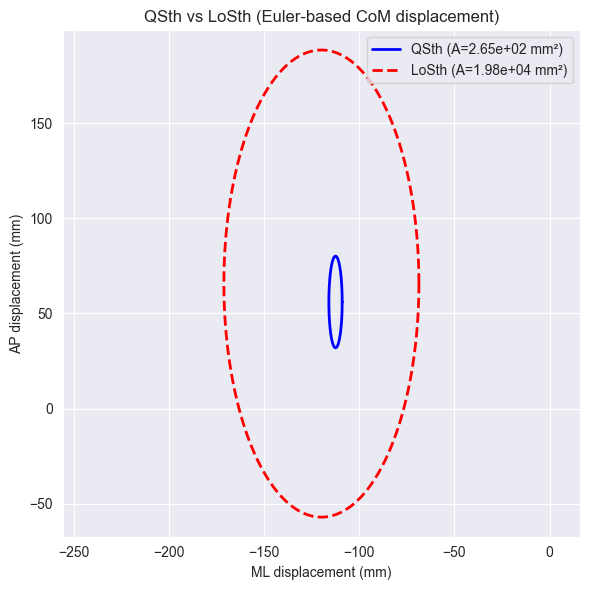

✅ Using EKF-derived Euler angles (pitch/yaw).


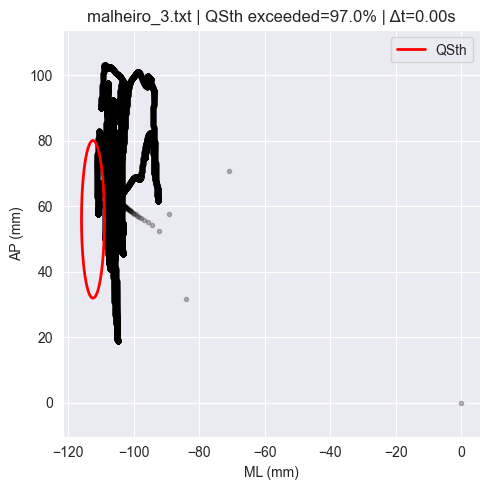

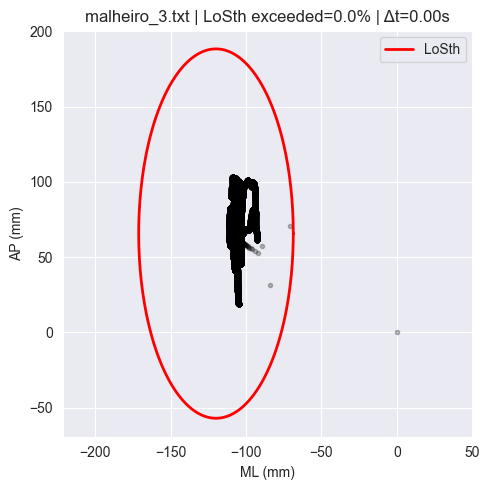

✅ Using EKF-derived Euler angles (pitch/yaw).


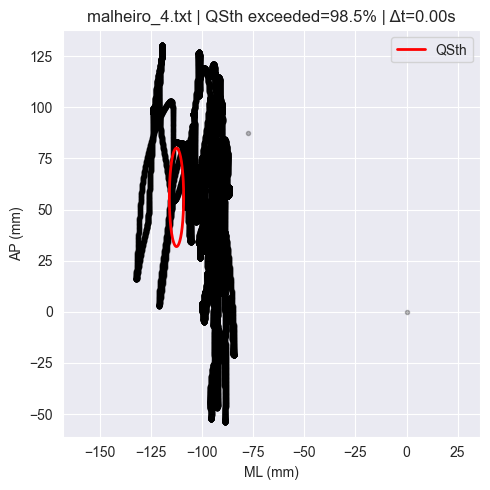

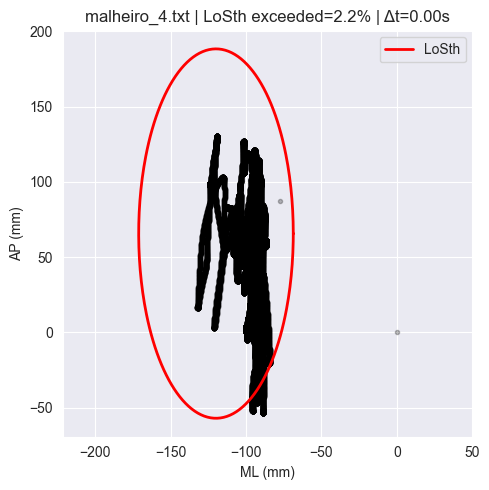

✅ Using EKF-derived Euler angles (pitch/yaw).


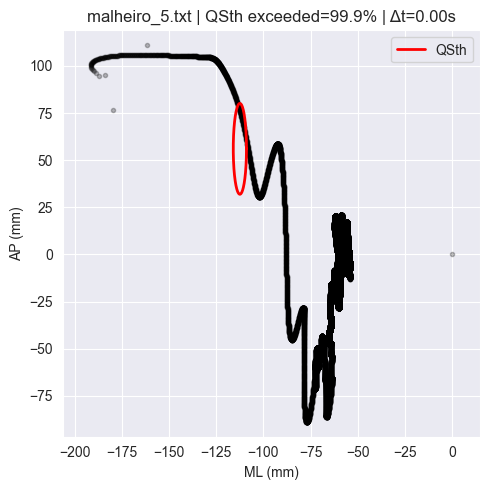

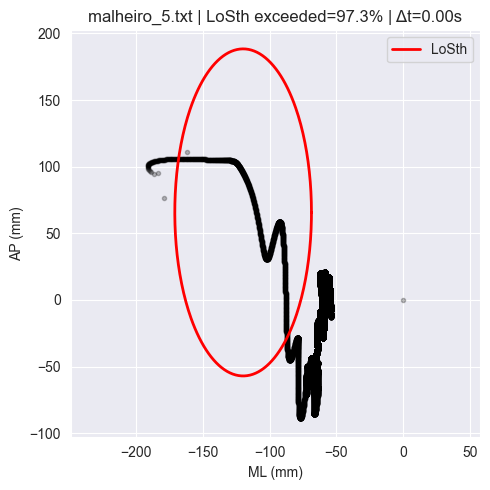

✅ Using EKF-derived Euler angles (pitch/yaw).


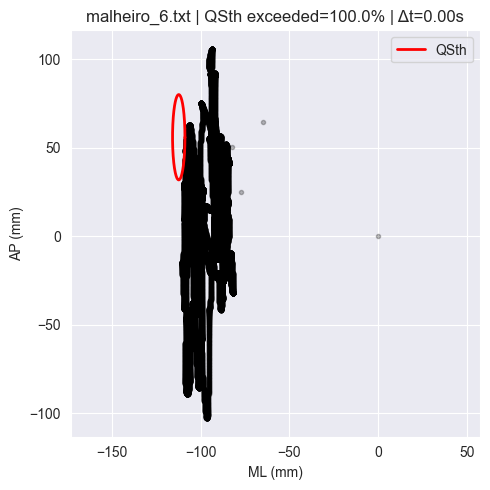

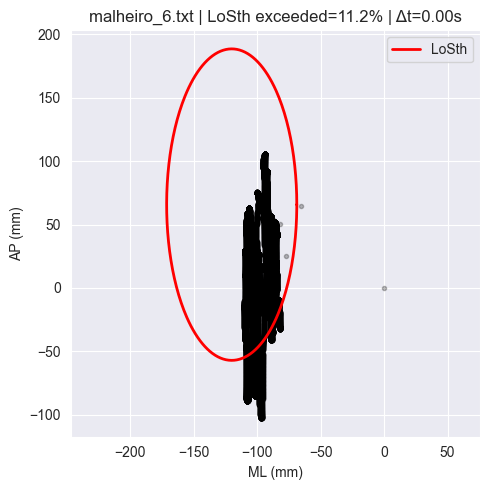


=== Threshold Exceedance Summary ===
            Trial Threshold  Prop_Exceeded_%  Delta_t_s
0  malheiro_3.txt      QSth        97.017790        0.0
1  malheiro_3.txt     LoSth         0.001613        0.0
2  malheiro_4.txt      QSth        98.463391        0.0
3  malheiro_4.txt     LoSth         2.228645        0.0
4  malheiro_5.txt      QSth        99.866265        0.0
5  malheiro_5.txt     LoSth        97.281794        0.0
6  malheiro_6.txt      QSth       100.000000        0.0
7  malheiro_6.txt     LoSth        11.161918        0.0


In [12]:
# =========================
# CONFIG
# =========================
sensor_id = 12  # 13 for lumbar and 12 for sternum
imu_acc_tag  = f"Imu_{sensor_id}_ImuAcc"
imu_gyr_tag  = f"Imu_{sensor_id}_ImuGyro"
imu_mag_tag  = f"Imu_{sensor_id}_ImuMag"
imu_euler_tag = f"Imu_{sensor_id}_ImuEuler"  # if Euler are already exported (optional)

baseline_trials = [1,2]   # QSth
los_trials      = [7]   # LoSth  (pick the most “dynamic” trials in your set)
L_fixed = 1190            # mm (ankle-to-CoM estimate)
#scaling_factor = np.sqrt(0.0077)  # Johansson factor

# =========================
# HELPERS
# =========================
def calculate_horizontal_displacement_direct(fixed_leg_length_mm, angle_series_degrees):
    """Horizontal displacement q = L * sin(phi) from angles in degrees (returns mm)."""
    return fixed_leg_length_mm * np.sin(np.radians(angle_series_degrees))

def _get_time_col(df):
    # Accepts 'Time(s):' or 'Time(s)'
    tcols = [c for c in df.columns if c.startswith("Time(")]
    if not tcols:
        tcols = [c for c in df.columns if "Time" in c]
    if not tcols:
        raise ValueError("No time column found.")
    col = tcols[0]
    if col != 'Time(s)':
        df = df.rename(columns={col: 'Time(s)'})
    return df

def _extract_matrix(df, base_tag, suffixes):
    """Find columns like f'{base_tag} :X(...):', '...:Y...', '...:Z...'"""
    def find_axis(axis):
        cands = [c for c in df.columns if base_tag in c and f":{axis}" in c]
        if not cands:
            raise ValueError(f"Missing axis {axis} for {base_tag}")
        return cands[0]
    cols = [find_axis("X"), find_axis("Y"), find_axis("Z")]
    return df[cols].to_numpy(), cols

def compute_euler_angles_EKF(df):
    """Compute Euler angles (roll, pitch, yaw) via EKF from IMU acc/gyro/mag."""
    df = _get_time_col(df)
    acc_np, acc_cols = _extract_matrix(df, imu_acc_tag, ("X","Y","Z"))
    gyr_np, gyr_cols = _extract_matrix(df, imu_gyr_tag, ("X","Y","Z"))
    mag_np, mag_cols = _extract_matrix(df, imu_mag_tag, ("X","Y","Z"))

    # --- Unit conversions ---
    if "(g):" in acc_cols[0]:
        acc_np = acc_np * 9.81
    if "(D/s):" in gyr_cols[0]:
        gyr_np = np.deg2rad(gyr_np)
    if "μT" in mag_cols[0]:
        mag_np = mag_np * 1e-3

    t = df['Time(s)'].to_numpy()
    fs = 1.0 / np.mean(np.diff(t))

    ekf = EKF(gyr=gyr_np, acc=acc_np, mag=mag_np, frequency=fs)
    euler_rad = np.array([q2euler(q_) for q_ in ekf.Q])
    return np.degrees(euler_rad), t

def extract_displacement_from_euler(df, L=L_fixed):
    df = _get_time_col(df)
    euler_exported_cols = [c for c in df.columns if imu_euler_tag in c]
    if euler_exported_cols:
        def axis_col(axis):
            cs = [c for c in df.columns if imu_euler_tag in c and f":{axis}" in c]
            if not cs: raise ValueError(f"Euler axis {axis} not found for {imu_euler_tag}")
            return cs[0]
        pitch_deg  = df[axis_col("Y")].to_numpy()  # ML sway
        yaw_deg = df[axis_col("Z")].to_numpy()  # AP sway
        t = df['Time(s)'].to_numpy()
        print("✅ Using exported Euler angles (pitch/yaw).")
    else:
        euler_deg, t = compute_euler_angles_EKF(df)
        pitch_deg  = euler_deg[:, 1]  # ML sway
        yaw_deg = euler_deg[:, 2]  # AP sway
        print("✅ Using EKF-derived Euler angles (pitch/yaw).")

    # q = L * sin(phi) → in mm
    disp_ML = calculate_horizontal_displacement_direct(L, pitch_deg)   # ML
    disp_AP = calculate_horizontal_displacement_direct(L, yaw_deg)  # AP
    disp_ML -= disp_ML[0]; disp_AP -= disp_AP[0]
    return disp_AP, disp_ML, t

def compute_threshold_ellipse(AP, ML, k=2, scale=None):
    mu_AP, mu_ML = np.mean(AP), np.mean(ML)
    sigma_AP, sigma_ML = np.std(AP), np.std(ML)
    AP_low, AP_high = mu_AP - k*sigma_AP, mu_AP + k*sigma_AP
    ML_low, ML_high = mu_ML - k*sigma_ML, mu_ML + k*sigma_ML

    # Optional scale (e.g., to inflate QS to LoS using 1/sqrt(0.0077))
    if scale is not None:
        s = (1.0/np.sqrt(0.0077)) if scale == "QS_to_LoS" else float(scale)
        AP_low, AP_high = AP_low*s, AP_high*s
        ML_low, ML_high = ML_low*s, ML_high*s

    a = (ML_high - ML_low)/2.0
    b = (AP_high - AP_low)/2.0
    area = np.pi * a * b
    return {"center": (mu_ML, mu_AP), "radii": (a, b), "area": area}


# =========================
# BUILD QSth (baseline) & LoSth (dynamic) ELLIPSES
# =========================
# =========================
# BUILD QSth (baseline) & LoSth (dynamic) ELLIPSES
# =========================
def find_trial_file(trial_num, data_dict):
    """Find filename containing '_{trial_num}' in the dictionary keys."""
    for k in data_dict.keys():
        if f"_{trial_num}" in k:
            return k
    raise ValueError(f"❌ No file found containing '_{trial_num}' in name.")

# --- QSth (quiet standing / baseline) ---
AP_qs, ML_qs = [], []
for trial in baseline_trials:
    key = find_trial_file(trial, filtered_data)
    ML, AP, _ = extract_displacement_from_euler(filtered_data[key])
    AP_qs += list(AP)
    ML_qs += list(ML)

qs_ellipse = compute_threshold_ellipse(np.array(AP_qs), np.array(ML_qs))
print(f"QSth area = {qs_ellipse['area']:.3e} mm²")

# --- LoSth (dynamic / limit of stability) ---
AP_los, ML_los = [], []
for trial in los_trials:
    key = find_trial_file(trial, filtered_data)
    ML, AP, _ = extract_displacement_from_euler(filtered_data[key])
    AP_los += list(AP)
    ML_los += list(ML)

los_ellipse = compute_threshold_ellipse(np.array(AP_los), np.array(ML_los))
print(f"LoSth area = {los_ellipse['area']:.3e} mm²")


# normalize displacement for visualization


# =========================
# VISUALIZE BOTH ELLIPSES
# =========================
theta = np.linspace(0, 2*np.pi, 300)
def ellipse_xy(ell):
    a, b = ell["radii"]
    cx, cy = ell["center"]
    return a*np.cos(theta) + cx, b*np.sin(theta) + cy

ex_qs, ey_qs = ellipse_xy(qs_ellipse)
ex_los, ey_los = ellipse_xy(los_ellipse)

plt.figure(figsize=(6,6))
plt.plot(ex_qs,  ey_qs,  'b-',  lw=2, label=f"QSth (A={qs_ellipse['area']:.2e} mm²)")
plt.plot(ex_los, ey_los, 'r--', lw=2, label=f"LoSth (A={los_ellipse['area']:.2e} mm²)")
plt.xlabel("ML displacement (mm)")
plt.ylabel("AP displacement (mm)")
plt.axis("equal"); plt.grid(True); plt.legend()
plt.title("QSth vs LoSth (Euler-based CoM displacement)")
plt.tight_layout(); plt.show()

# =========================
# EXCEEDANCE ANALYSIS
# =========================
results = []
for fname, df in filtered_data.items():
    if any(f"{t}" in fname for t in baseline_trials + los_trials):
        continue

    ML, AP, tvec = extract_displacement_from_euler(df)

    # normalize displacement for visualization
    AP -= AP[0]
    ML -= ML[0]


    for label, ell in [("QSth", qs_ellipse), ("LoSth", los_ellipse)]:
        cx, cy = ell["center"]; a, b = ell["radii"]
        norm = ((ML - cx)**2 / a**2) + ((AP - cy)**2 / b**2)
        exceeded = norm > 1.0
        prop_exceeded = 100.0 * np.mean(exceeded)
        t_exceed = (tvec[np.argmax(exceeded)] - tvec[0]) if np.any(exceeded) else np.nan

        results.append({
            "Trial": fname,
            "Threshold": label,
            "Prop_Exceeded_%": prop_exceeded,
            "Delta_t_s": t_exceed
        })

        ex, ey = ellipse_xy(ell)
        plt.figure(figsize=(5,5))
        plt.plot(ML, AP, 'k.', alpha=0.25)
        plt.plot(ex, ey, 'r-', lw=2, label=f"{label}")
        plt.title(f"{fname} | {label} exceeded={prop_exceeded:.1f}% | Δt={t_exceed if t_exceed==t_exceed else float('nan'):.2f}s")
        plt.xlabel("ML (mm)"); plt.ylabel("AP (mm)")
        plt.axis("equal"); plt.grid(True); plt.legend()
        plt.tight_layout(); plt.show()

threshold_df = pd.DataFrame(results)
print("\n=== Threshold Exceedance Summary ===")
print(threshold_df)


# Balance Score
- **QSth:** Measures fine postural control (stability precision)
- **LoSth:** Measures the subject’s capacity before instability (stability range)

### Derived Metrics
**Prop_Exceeded_%**  
Percentage of time the CoM trajectory exceeds the ellipse boundary.  
→ Lower values indicate better stability.

**Delta_t_s**  
Time to first exceedance (in seconds).  
→ Higher values indicate greater control and steadiness.

**Balance Stability Index (BSI_QSth)**  
`BSI_QSth = 1 - (Prop_Exceeded_QSth / 100)`  
Represents the proportion of stable time within the QSth ellipse.

**LoS Margin Index**  
`LoS_Margin_Index = 1 - (Prop_Exceeded_LoSth / 100)`  
Indicates how far the subject remains from their limit of stability.

**Composite Balance Score (0–100)**  
Combines fine stability and overall balance range:  
`Balance_Score = 100 * (0.7 * BSI_QSth + 0.3 * LoS_Margin_Index)`  
Weighted 70% toward QSth precision and 30% toward dynamic stability capacity.

### Score Classification
| Score Range | Category    | Interpretation              |
|--------------|-------------|-----------------------------|
| ≥ 90         | Excellent   | Very stable posture         |
| 75–89        | Good        | Minor sway control issues   |
| 60–74        | Moderate    | Noticeable instability      |
| < 60         | Poor        | High fall risk              |


=== Derived Balance Indices ===
            Trial  Prop_Exceeded_QSth  Prop_Exceeded_LoSth  BSI_QSth  \
0  malheiro_3.txt            0.001613            97.017790  0.999984   
1  malheiro_4.txt            2.228645            98.463391  0.977714   
2  malheiro_5.txt           97.281794            99.866265  0.027182   
3  malheiro_6.txt           11.161918           100.000000  0.888381   

   BSI_LoSth  Stability_Capacity_Ratio    Interpretation  
0   0.029822                 74.571527            Stable  
1   0.015366                 74.571527            Stable  
2   0.001337                 74.571527          Unstable  
3   0.000000                 74.571527  Mild instability  

Summary saved to: DDM_2025_2026_EMG/balance_indices_summary.csv


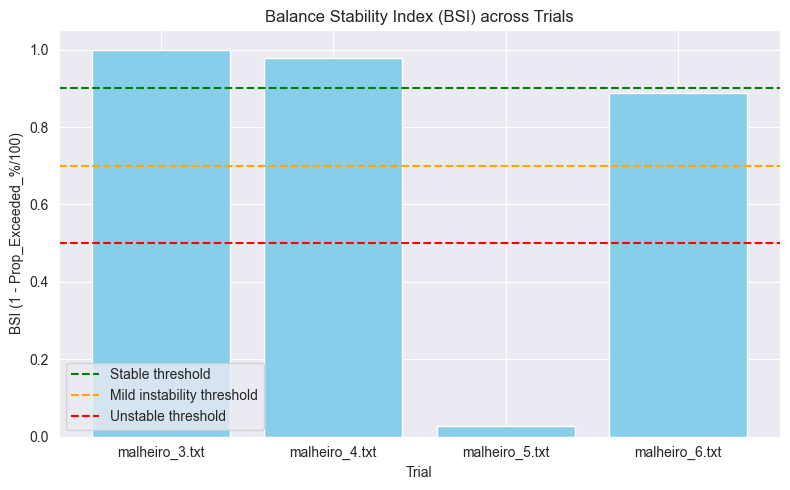

In [13]:
# ===============================================================
# STEP 6 — DERIVE BALANCE INDICES
# ===============================================================

# --- 1️⃣ Compute BSI (Balance Stability Index) ---
# BSI = 1 - (Prop_Exceeded_% / 100)
threshold_df["BSI"] = 1 - (threshold_df["Prop_Exceeded_%"] / 100)

# --- 2️⃣ Compute Threshold Ratio (LoSth / QSth area) ---
# You already have ellipse areas from earlier code:
qs_area = qs_ellipse["area"]
los_area = los_ellipse["area"]
stability_capacity_ratio = los_area / qs_area

# --- 3️⃣ Aggregate summary statistics per trial ---
summary = (
    threshold_df
    .pivot(index="Trial", columns="Threshold", values=["Prop_Exceeded_%", "BSI"])
    .reset_index()
)

# flatten column MultiIndex
summary.columns = [
    "Trial",
    "Prop_Exceeded_QSth", "Prop_Exceeded_LoSth",
    "BSI_QSth", "BSI_LoSth"
]

summary["Stability_Capacity_Ratio"] = stability_capacity_ratio

# --- 4️⃣ Add qualitative interpretation ---
def interpret_balance(row):
    qs = row["Prop_Exceeded_QSth"]
    if qs < 5:
        return "Stable"
    elif qs < 30:
        return "Mild instability"
    else:
        return "Unstable"

summary["Interpretation"] = summary.apply(interpret_balance, axis=1)

# --- 5️⃣ Display results ---
print("\n=== Derived Balance Indices ===")
print(summary)

# --- 6️⃣ Optional: Save summary ---
summary_path = "DDM_2025_2026_EMG/balance_indices_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"\nSummary saved to: {summary_path}")

# --- 7️⃣ Optional Visualization ---
plt.figure(figsize=(8,5))
plt.bar(summary["Trial"], summary["BSI_QSth"], color="skyblue")
plt.axhline(0.9, color="green", linestyle="--", label="Stable threshold")
plt.axhline(0.7, color="orange", linestyle="--", label="Mild instability threshold")
plt.axhline(0.5, color="red", linestyle="--", label="Unstable threshold")
plt.title("Balance Stability Index (BSI) across Trials")
plt.xlabel("Trial")
plt.ylabel("BSI (1 - Prop_Exceeded_%/100)")
plt.legend()
plt.tight_layout()
plt.show()



=== Composite Balance Score (0–100) ===
            Trial  Balance_Score Balance_Score_Label    Interpretation
0  malheiro_3.txt      70.893534            Moderate            Stable
1  malheiro_4.txt      68.900931            Moderate            Stable
2  malheiro_5.txt       1.942865                Poor          Unstable
3  malheiro_6.txt      62.186658            Moderate  Mild instability


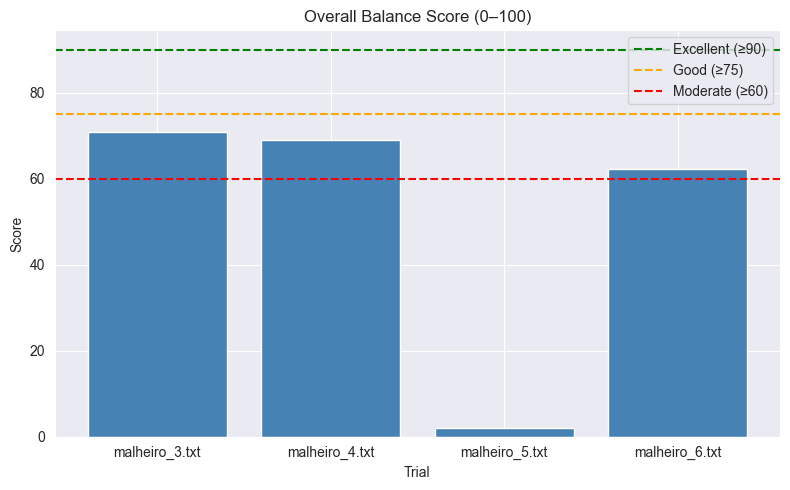

In [10]:
# ===============================================================
# STEP 7 — COMPOSITE BALANCE SCORE (0–100)
# ===============================================================

# Define weighting factors (you can tune these later)
# The idea: 70% weight on stability within QSth (fine control)
#           30% weight on remaining margin before LoSth (capacity)
w_qs, w_los = 0.7, 0.3

# --- 1️⃣ Compute LoS Margin Index ---
# Since LoSth exceedance is ideally 0%, use inverse of exceedance as a normalized margin
summary["LoS_Margin_Index"] = 1 - (summary["Prop_Exceeded_LoSth"] / 100)
summary["LoS_Margin_Index"] = summary["LoS_Margin_Index"].clip(0, 1)

# --- 2️⃣ Compute Composite Balance Score ---
summary["Balance_Score"] = (
    100 * (
        w_qs * summary["BSI_QSth"] +
        w_los * summary["LoS_Margin_Index"]
    )
)

# --- 3️⃣ Qualitative Label for Balance Score ---
def classify_score(score):
    if score >= 90:
        return "Excellent"
    elif score >= 75:
        return "Good"
    elif score >= 60:
        return "Moderate"
    else:
        return "Poor"

summary["Balance_Score_Label"] = summary["Balance_Score"].apply(classify_score)

# --- 4️⃣ Display Results ---
print("\n=== Composite Balance Score (0–100) ===")
print(summary[["Trial", "Balance_Score", "Balance_Score_Label", "Interpretation"]])

# --- 5️⃣ Visualization ---
plt.figure(figsize=(8,5))
plt.bar(summary["Trial"], summary["Balance_Score"], color="steelblue")
plt.axhline(90, color="green", linestyle="--", label="Excellent (≥90)")
plt.axhline(75, color="orange", linestyle="--", label="Good (≥75)")
plt.axhline(60, color="red", linestyle="--", label="Moderate (≥60)")
plt.title("Overall Balance Score (0–100)")
plt.xlabel("Trial")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()
